In [1]:
import numpy as np

import torch
import torch.utils.data

import datasets
import metaimage
import nnet
import voxgrid
import display

%load_ext autoreload
%autoreload 2

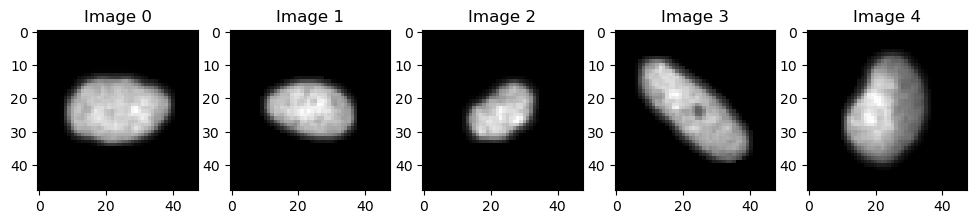

In [12]:
IMAGE_SIZE = (48, 48)
SPACE_SIZE = (48, 48, 48)

BATCH_SIZE = 100

IMG_FOLDER = "images/bbbc039/images/"

train_imgs, val_imgs = datasets.split_folder(IMG_FOLDER, 0.9, max_images=2500)

train_auto_dataset = datasets.Images(IMG_FOLDER, train_imgs, train=True)
val_auto_dataset = datasets.Images(IMG_FOLDER, val_imgs)

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            (f"Image {i}", train_auto_dataset[i][0]) for i in range(5)
        ]
    ],
    figsize=(12, 12),
)
display.show()

In [13]:

LATENT_SIZE = 128
BASE_CHANNELS = 16
DISCRIMINATOR_CHANNELS = 4
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.2
GENERATOR_DROPOUT = 0.1

discriminator = torch.nn.Sequential(
    nnet.blocks.conv.BasicConvBlock(
        in_channels=1,
        out_channels=DISCRIMINATOR_CHANNELS,
        kernel_size=1,
        activation=ACTIVATION,
    ),
    nnet.blocks.conv.ResizeStack(
        in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0], IMAGE_SIZE[1]),
        out_shape=(DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
        layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
            stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
            activation=ACTIVATION,
            dropout=DISCRIMINATOR_DROPOUT,
        ),
        resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
            activation=ACTIVATION,
            dropout=DISCRIMINATOR_DROPOUT,
        ),
        layer_factories_per_downsample=1,
    ),
    nnet.blocks.conv.ConvToLinear(
        (DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
        out_dim=1,
        activation=torch.nn.Sigmoid,
    ),
)

generator = nnet.generators.TransGrayMaskGenerator(
    torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BASE_CHANNELS * (SPACE_SIZE[0] // 2), 2, 2, 2),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BASE_CHANNELS * (SPACE_SIZE[0] // 2), 2, 2, 2),
            out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
            layer_factory=nnet.blocks.resnet.create_resnet_3d_factory(
                stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                use_3d=True,
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            total_layers=5,
        ),
        nnet.blocks.resnet.create_resnet_block_simple_3d(
            in_channels=BASE_CHANNELS,
            out_channels=BASE_CHANNELS,
            activation=ACTIVATION,
            stochastic_depth_rate=GENERATOR_DROPOUT,
            kernel_size=3,
        ),
        nnet.blocks.conv.BasicConvBlock(
            use_3d=True,
            in_channels=BASE_CHANNELS,
            out_channels=2,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
    ),
    IMAGE_SIZE,
)

gan_trainer = nnet.training.GANTrainer(
    generator,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=5e-4,
)

model_path = "models/bbbc039_img_gan"

In [14]:
gan_trainer.train(
    train_auto_loader,
    val_auto_loader,
    51,
    path=model_path,
    noise=0.3,
    gen_train_thresh=1.25,
    dis_train_thresh=1.25,
)

Epoch 0/51 | val loss (gen/dis): -/- | train loss: 0.00(0)/0.00(0):   0%|          | 0/51 [01:02<?, ?it/s]


KeyboardInterrupt: 

Model models/bbbc039_img_gan_7.pt is loaded from epoch 70 , loss 0.9208
Model models/bbbc039_img_gan_8.pt is loaded from epoch 80 , loss 0.8178
Model models/bbbc039_img_gan_9.pt is loaded from epoch 90 , loss 0.8032
Model models/bbbc039_img_gan_10.pt is loaded from epoch 100 , loss 1.1525
Model models/bbbc039_img_gan_11.pt is loaded from epoch 110 , loss 1.4406
Model models/bbbc039_img_gan_12.pt is loaded from epoch 120 , loss 1.9920


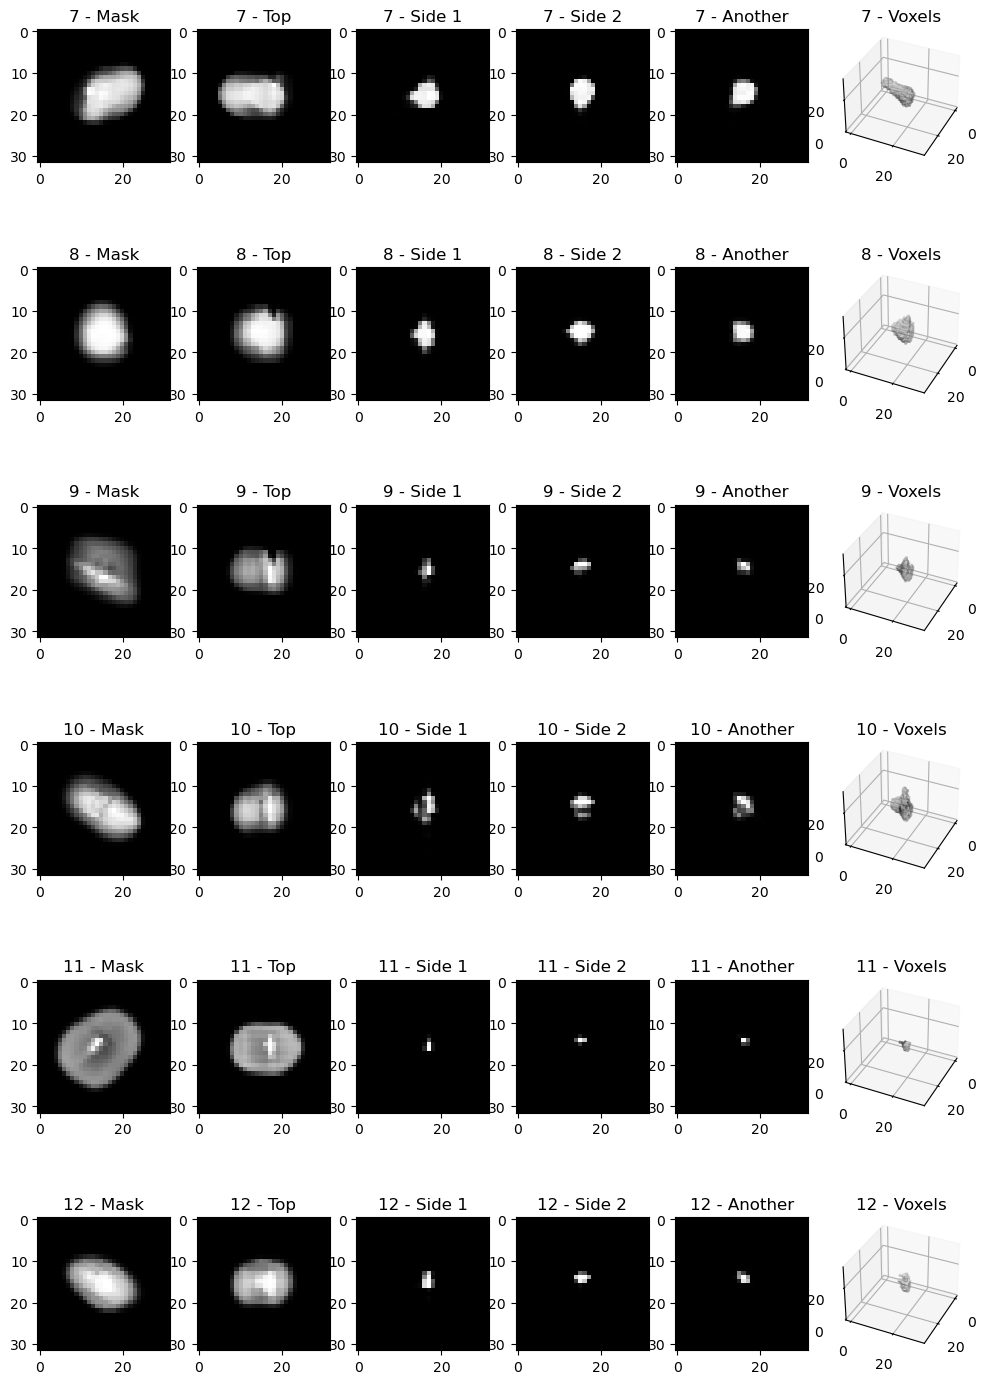

In [10]:
MODELS = (7, 12)

generator.eval()
generator.to("cuda")

N_MODELS = MODELS[1] - MODELS[0] + 1

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for i in range(N_MODELS):
    model_n = MODELS[0] + i
    gan_trainer.load_state(f"{model_path}_{model_n}.pt")

    mask = metaimage.Mask.from_tensor(
        generator(gen_input)[0], title=f"{model_n} - Mask"
    )
    voxels = voxgrid.GrayVoxel.from_tensor(
        generator.voxel_generator(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.create_image(y_angle=np.pi / 2)),
            (f"{model_n} - Side 2", voxels.create_image(x_angle=np.pi / 2)),
            (f"{model_n} - Another", voxels.create_image(np.pi / 4, np.pi / 4)),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * N_MODELS))
display.show()

Model models/bbbc039_img_gan_12.pt is loaded from epoch 120 , loss 1.9920


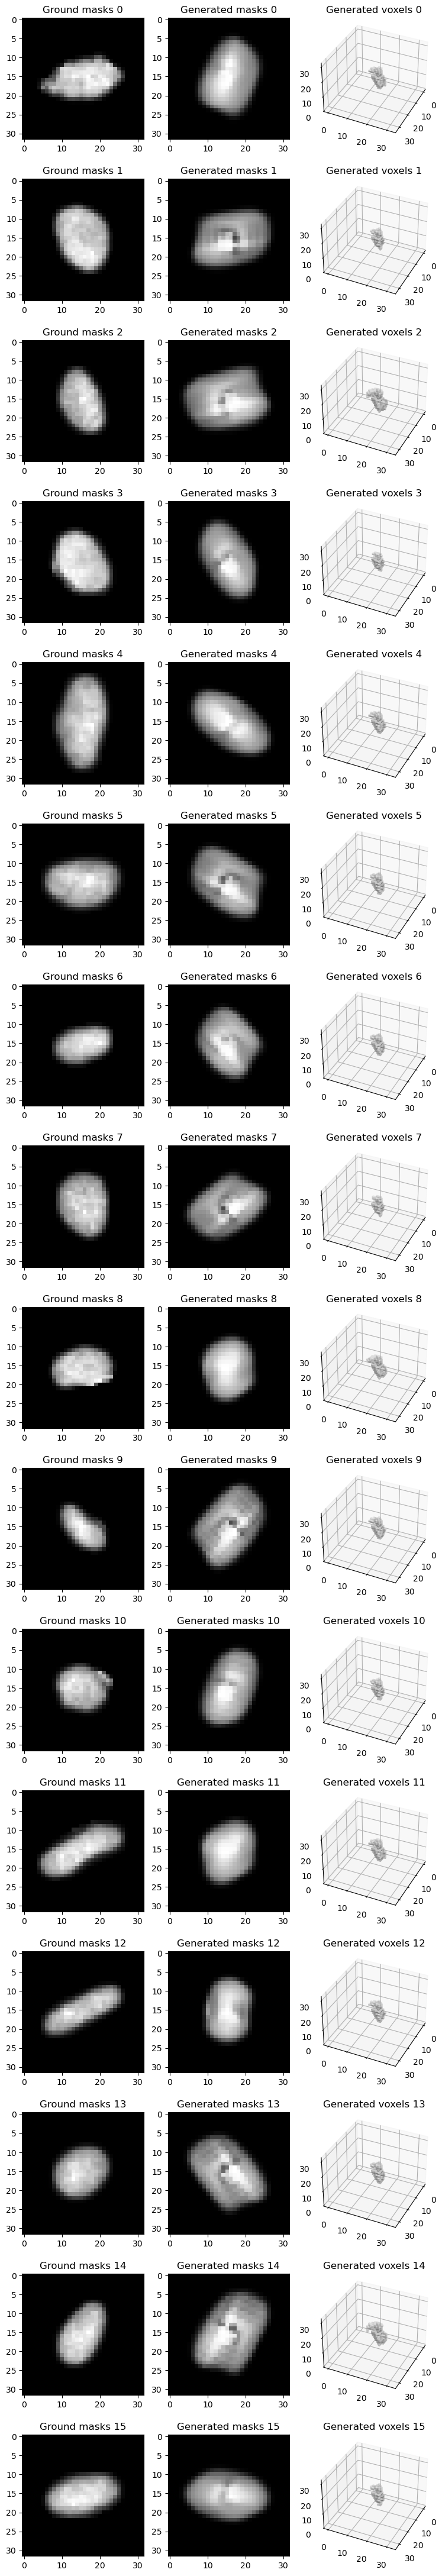

In [11]:
MODEL = 12

N_SAMPLES = 16

TRAIN_BASIS = 14

gan_trainer.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(N_SAMPLES+1, LATENT_SIZE))).cuda()

masks = generator(gen_input)
voxels = generator.voxel_generator(gen_input)

plot_grid = []

for i in range(N_SAMPLES):
    cur_voxels = voxgrid.GrayVoxel.from_tensor(voxels[i], title=f"Generated voxels {i}")
    cur_mask = metaimage.Mask.from_tensor(masks[i], title=f"Generated masks {i}")
    ground_mask = train_auto_dataset[i+TRAIN_BASIS][1]
    ground_mask = metaimage.Mask.from_tensor(ground_mask, title=f"Ground masks {i}")

    plot_grid.append([ground_mask, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(9, N_SAMPLES*3.5))
display.show()